<a href="https://colab.research.google.com/github/t4nti3n/powershell_detection_multimodel_multioutput/blob/gan/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GAN#


## [1]: Load data

### load and view

In [1]:
import pandas as pd

file_path = './dataset/fusion_with_vector_extended.csv'

try:
  df = pd.read_csv(file_path)
  print("Dataset loaded successfully.")
  print(df.head())
except FileNotFoundError:
  print(f"Error: File not found at {file_path}. Please check the file path.")
except Exception as e:
  print(f"An error occurred: {e}")


Dataset loaded successfully.
                                        Full Payload       Label  \
0  \C:\\Windows\\System32\\WindowsPowerShell\\v1....    Injector   
1  \C:\\Windows\\System32\\WindowsPowerShell\\v1....  Downloader   
2  \C:\\Windows\\System32\\WindowsPowerShell\\v1....    Injector   
3  powershell.exe -nop -wind hidden -Exec Bypass ...     Payload   
4  powershell -window hidden -enc $1 = '$c = ''[D...    Injector   

                                        FusionVector  
0  -0.18999852 -0.48553216 -0.87083316 0.2666215 ...  
1  -0.3947524 0.010655806 -0.67612636 -0.07839656...  
2  -0.1899367 -0.5148512 -0.90198445 0.2528152 -0...  
3  -0.17432946 0.028123861 -0.5588947 -0.03192398...  
4  -0.24262634 -0.5209265 -0.8235193 0.15971158 -...  


In [2]:
import os

output_dir = "./GAN/"
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, "sample_fushion.csv")

df.head().to_csv(output_file, index=False)


## [2]: Defined Discriminator

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

# Load and preprocess dataset
def load_and_preprocess_data(csv_path, feature_dim=512):
    # Load CSV
    data = pd.read_csv(csv_path)

    # Parse FusionVector (space-separated string to array)
    features = np.array([np.fromstring(vec, sep=' ') for vec in data['FusionVector']])

    # Validate feature dimension
    assert features.shape[1] == feature_dim, f"Expected {feature_dim} features, got {features.shape[1]}"

    # Encode labels
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(data['Label'])

    # Normalize features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    # Convert to PyTorch tensors
    features = torch.FloatTensor(features)
    labels = torch.LongTensor(labels)

    return features, labels, scaler, label_encoder

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes=5):  # Assuming 5 classes based on the error
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)  # Output layer for num_classes
        )

    def forward(self, x):
        return self.model(x)

# Train and evaluate discriminator
def train_discriminator(discriminator, features, labels, test_size=0.2, epochs=50, batch_size=64, lr=0.0002):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test_size, stratify=labels, random_state=42
    )

    # Optimizer and loss
    optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    class_loss = nn.CrossEntropyLoss()

    # Training loop
    discriminator.train()
    for epoch in range(epochs):
        total_loss = 0  # To accumulate loss for the epoch
        num_batches = 0  # To count batches for averaging loss

        for i in range(0, len(X_train), batch_size):
            batch_features = X_train[i:i+batch_size]
            batch_labels = y_train[i:i+batch_size]

            optimizer.zero_grad()
            outputs = discriminator(batch_features)

            # Check if any label is out of bounds and adjust if necessary
            # This step handles potential issues with the dataset
            invalid_labels = (batch_labels >= discriminator.model[-1].out_features).nonzero()
            if invalid_labels.nelement() > 0:
                # Print or handle invalid labels (e.g., replace with max valid label)
                print(f"Warning: Invalid labels found in batch: {batch_labels[invalid_labels]}")
                batch_labels[invalid_labels] = discriminator.model[-1].out_features - 1

            loss = class_loss(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()  # Accumulate loss
            num_batches += 1  # Increment batch count

        if (epoch + 1) % 10 == 0:
            avg_loss = total_loss / num_batches  # Calculate average loss
            print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")

    # Evaluate
    discriminator.eval()
    with torch.no_grad():
        test_outputs = discriminator(X_test)
        test_preds = torch.argmax(test_outputs, dim=1)
        accuracy = accuracy_score(y_test.numpy(), test_preds.numpy())

    print(f"Discriminator Test Accuracy: {accuracy:.4f}")
    return accuracy, X_train, y_train, X_test, y_test, scaler, label_encoder

# Main execution
if __name__ == "__main__":
    # Hyperparameters
    feature_dim = 512  # From dataset
    batch_size = 64
    epochs = 50
    accuracy_threshold = 0.7  # Adjust as needed

    # Load dataset (replace with your CSV path)
    csv_path = "./dataset/fusion_with_vector_extended.csv"  # Placeholder
    features, labels, scaler, label_encoder = load_and_preprocess_data(csv_path, feature_dim)

    # Initialize discriminator
    discriminator = Discriminator(feature_dim)

    # Train and evaluate
    accuracy, X_train, y_train, X_test, y_test, scaler, label_encoder = train_discriminator(
        discriminator, features, labels, epochs=epochs, batch_size=batch_size
    )

    # Save model if satisfactory
    if accuracy >= accuracy_threshold:
        torch.save(discriminator.state_dict(), "./GAN/discriminator_model.pth")
        print("Discriminator model saved as 'discriminator_model.pth'")
        # Save scaler and label encoder for GAN
        np.save("./GAN/scaler_params.npy", [scaler.mean_, scaler.scale_])
        np.save("./GAN/label_encoder_classes.npy", label_encoder.classes_)
        print("Scaler and label encoder saved")
    else:
        print("Discriminator accuracy below threshold. Adjust model or hyperparameters.")

#The code below was improperly indented and is now moved to within the main execution block.
#It has also been edited to provide more information about invalid labels if they are found.
    # Check for invalid labels after training
    # This step can now use label_encoder which is defined in this scope.
    for i in range(0, len(X_train), batch_size):
        batch_features = X_train[i : i + batch_size]
        batch_labels = y_train[i : i + batch_size]
        invalid_labels = (batch_labels >= discriminator.model[-1].out_features).nonzero()
        if invalid_labels.nelement() > 0:
            for idx in invalid_labels:
                invalid_label_value = batch_labels[idx].item()
                print(f"Warning: Invalid label found: {invalid_label_value}.  "
                      f"Original Label: {label_encoder.inverse_transform([invalid_label_value])}, "
                      f"Max valid label: {discriminator.model[-1].out_features - 1}")
            batch_labels[invalid_labels] = discriminator.model[-1].out_features - 1


Epoch 10/50, Average Loss: 0.1411
Epoch 20/50, Average Loss: 0.0823
Epoch 30/50, Average Loss: 0.0552
Epoch 40/50, Average Loss: 0.0467
Epoch 50/50, Average Loss: 0.0364
Discriminator Test Accuracy: 0.9746
Discriminator model saved as 'discriminator_model.pth'
Scaler and label encoder saved


In [4]:

# Load the saved scaler and label encoder
scaler_params = np.load("./GAN/scaler_params.npy", allow_pickle=True)
label_encoder_classes = np.load("./GAN/label_encoder_classes.npy", allow_pickle=True)

# Recreate the scaler and label encoder
scaler = StandardScaler()
scaler.mean_ = scaler_params[0]
scaler.scale_ = scaler_params[1]
label_encoder = LabelEncoder()
label_encoder.classes_ = label_encoder_classes

# Example: Show original labels for the first 10 data points in the test set
print("Original labels for the first 10 data points in the test set:")
for i in range(10):  # Adjust range as needed
        original_label = label_encoder.inverse_transform([y_test[i].item()])[0]
        print(f"Data point {i+1}: Original Label = {original_label}, Encoded Label = {y_test[i].item()}")



Original labels for the first 10 data points in the test set:
Data point 1: Original Label = Injector, Encoded Label = 2
Data point 2: Original Label = Injector, Encoded Label = 2
Data point 3: Original Label = Downloader, Encoded Label = 1
Data point 4: Original Label = Bypass, Encoded Label = 0
Data point 5: Original Label = Payload, Encoded Label = 3
Data point 6: Original Label = Downloader, Encoded Label = 1
Data point 7: Original Label = Payload, Encoded Label = 3
Data point 8: Original Label = TaskExecution, Encoded Label = 4
Data point 9: Original Label = Downloader, Encoded Label = 1
Data point 10: Original Label = TaskExecution, Encoded Label = 4


## [3]: Gen Noising Data

### Load discriminotr and Gen data

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Display labels and encodings
def display_labels(data, num_samples=10):
    valid_labels = {'Bypass', 'Downloader', 'Injector', 'Payload', 'TaskExecution'}
    data = data[data['Label'].isin(valid_labels)]

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(data['Label'])

    unique_labels = label_encoder.classes_
    print(f"All unique labels: {unique_labels}")
    print(f"Number of unique labels: {len(unique_labels)}")

    print(f"\nOriginal and encoded labels for the first {min(num_samples, len(data))} data points:")
    for i in range(min(num_samples, len(data))):
        print(f"Data point {i+1}: Original Label = {data['Label'].iloc[i]}, Encoded Label = {encoded_labels[i]}")

    return label_encoder.classes_

# Load and preprocess dataset
def load_and_preprocess_data(csv_path, scaler_params, feature_dim=512):
    data = pd.read_csv(csv_path)
    valid_labels = {'Bypass', 'Downloader', 'Injector', 'Payload', 'TaskExecution'}

    original_rows = len(data)
    data = data[data['Label'].isin(valid_labels)]
    removed_rows = original_rows - len(data)
    if removed_rows > 0:
        print(f"Removed {removed_rows} rows with invalid labels.")
    else:
        print("No rows with invalid labels found.")

    if data.empty:
        raise ValueError("No rows remain after filtering. Check dataset labels.")

    unique_labels = data['Label'].unique()
    print(f"Unique labels after filtering: {unique_labels}")

    features = np.array([np.fromstring(vec, sep=' ') for vec in data['FusionVector']])
    assert features.shape[1] == feature_dim, f"Expected {feature_dim} features, got {features.shape[1]}"

    scaler = StandardScaler()
    scaler.mean_, scaler.scale_ = scaler_params[0], scaler_params[1]
    features = scaler.transform(features)

    features = torch.FloatTensor(features)
    return features, data, scaler

# Discriminator Model (Matches training script)
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Generator Model
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        noise = torch.randn_like(x) * 0.05
        return self.model(x + noise)

# Train GAN
def train_gan(discriminator, generator, features, noise_dim=100, epochs=200, batch_size=64, lr=0.0002):
    g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    class_loss = nn.CrossEntropyLoss()  # Use classification loss since discriminator is a classifier

    discriminator.eval()
    for param in discriminator.parameters():
        param.requires_grad = False

    generator.train()
    for epoch in range(epochs):
        total_g_loss = 0
        for i in range(0, len(features), batch_size):
            real_data = features[i:i+batch_size]
            batch_size_actual = real_data.size(0)

            noise = torch.randn(batch_size_actual, noise_dim)
            fake_data = generator(noise)
            # Generate random labels for fake data (simulating classification)
            fake_labels = torch.randint(0, discriminator.model[-1].out_features, (batch_size_actual,))

            g_optimizer.zero_grad()
            g_outputs = discriminator(fake_data)
            g_loss = class_loss(g_outputs, fake_labels)
            g_loss.backward()
            g_optimizer.step()
            total_g_loss += g_loss.item()

        if (epoch + 1) % 10 == 0:
            avg_g_loss = total_g_loss / (len(features) // batch_size + 1)
            print(f"Epoch {epoch+1}/{epochs}, Generator Loss: {avg_g_loss:.4f}")

    return generator

# Generate synthetic dataset
def generate_synthetic_dataset(generator, num_samples, noise_dim, scaler, label_encoder_classes, input_data, copy_payload=False):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, noise_dim)
        synthetic_data = generator(noise).numpy()

    synthetic_data = scaler.inverse_transform(synthetic_data)
    synthetic_labels = np.random.choice(label_encoder_classes, size=num_samples)

    if copy_payload:
        payload_values = input_data['Full Payload'].dropna().sample(num_samples, replace=True).values
    else:
        payload_values = [''] * num_samples

    synthetic_df = pd.DataFrame({
        'Full Payload': payload_values,
        'Label': synthetic_labels,
        'FusionVector': [' '.join(map(str, vec)) for vec in synthetic_data]
    })

    return synthetic_df

# Main execution
if __name__ == "__main__":
    # Hyperparameters
    feature_dim = 512
    noise_dim = 100
    batch_size = 64
    epochs = 200
    num_classes = 5
    copy_payload = False

    # Load dataset and scaler
    csv_path = "./dataset/fusion_with_vector_extended.csv"
    try:
        scaler_params = np.load("./GAN/scaler_params.npy", allow_pickle=True)
        features, original_data, scaler = load_and_preprocess_data(csv_path, scaler_params, feature_dim)
    except Exception as e:
        print(f"Error loading dataset or scaler: {e}")
        exit(1)

    # Display labels
    try:
        label_encoder_classes = display_labels(original_data)
        if len(label_encoder_classes) != num_classes:
            print(f"Warning: Expected {num_classes} labels, found {len(label_encoder_classes)}. Updating num_classes.")
            num_classes = len(label_encoder_classes)
    except Exception as e:
        print(f"Error processing labels: {e}")
        exit(1)

    # Load discriminator
    try:
        discriminator = Discriminator(feature_dim, num_classes)
        saved_state_dict = torch.load("./GAN/discriminator_model.pth")
        # Rename keys to match 'model' prefix
        model_state_dict = {k.replace('model.', ''): v for k, v in saved_state_dict.items()}
        discriminator.model.load_state_dict(model_state_dict)
        print("Discriminator model loaded successfully.")
    except Exception as e:
        print(f"Error loading discriminator model: {e}")
        print("Proceeding without loading saved discriminator weights.")

    # Initialize generator
    generator = Generator(noise_dim, feature_dim)

    # Train GAN
    try:
        generator = train_gan(discriminator, generator, features, noise_dim=noise_dim, epochs=epochs, batch_size=batch_size)
    except Exception as e:
        print(f"Error training GAN: {e}")
        exit(1)

    # Generate synthetic dataset
    try:
        synthetic_df = generate_synthetic_dataset(
            generator, len(original_data), noise_dim, scaler, label_encoder_classes, original_data, copy_payload=copy_payload
        )
        synthetic_df.to_csv("./GAN/synthetic_powershell_malware.csv", index=False, na_rep='')
        print("Synthetic dataset saved as './GAN/synthetic_powershell_malware.csv'")
    except Exception as e:
        print(f"Error generating synthetic dataset: {e}")
        exit(1)

Removed 3 rows with invalid labels.
Unique labels after filtering: ['Injector' 'Downloader' 'Payload' 'TaskExecution' 'Bypass']
All unique labels: ['Bypass' 'Downloader' 'Injector' 'Payload' 'TaskExecution']
Number of unique labels: 5

Original and encoded labels for the first 10 data points:
Data point 1: Original Label = Injector, Encoded Label = 2
Data point 2: Original Label = Downloader, Encoded Label = 1
Data point 3: Original Label = Injector, Encoded Label = 2
Data point 4: Original Label = Payload, Encoded Label = 3
Data point 5: Original Label = Injector, Encoded Label = 2
Data point 6: Original Label = Downloader, Encoded Label = 1
Data point 7: Original Label = Downloader, Encoded Label = 1
Data point 8: Original Label = Injector, Encoded Label = 2
Data point 9: Original Label = Downloader, Encoded Label = 1
Data point 10: Original Label = Downloader, Encoded Label = 1
Discriminator model loaded successfully.
Epoch 10/200, Generator Loss: 1.6183
Epoch 20/200, Generator Loss

## Test

## Test concept:
Context Recap
- Datasets:
A (Original): powershell_malware.csv, contains Full Payload (ignored), Label (5 classes: Bypass, Downloader, Injector, Payload, TaskExecution), and FusionVector (512 numerical features).
B (Synthetic): synthetic_powershell_malware.csv, generated by the GAN to bypass the discriminator, same format but with noisy FusionVector features.
- Models:
M1 (Fusion Model): Your provided TensorFlow model combining CNN, BiLSTM, Multi-Head Attention, and Dense layers, extended to handle 512 features (input shape (512, 1)).
M2 (Mono Model): Not specified, but I’ll assume a simpler model (e.g., a Multi-Layer Perceptron or single CNN) for contrast, also handling 512 features.
- Objective:
Compare M1 and M2 to highlight M1’s strengths (e.g., robustness to noise due to fusion of CNN, LSTM, and Transformer).
Assess their ability to handle noisy data (B) that aims to confuse the discriminator.
### aproach 1
Train M1 and M2 on A, Test on B
Process:
 - Train M1 on Dataset A’s training set.
 -  Train M2 on Dataset A’s training set.
 - Test both models on Dataset B’s test set.
 - Record accuracy for M1 and M2 on B.
 - Compare accuracies to evaluate which model better handles noisy data.
Evaluation Metric: Accuracy on B (possibly supplemented with loss or F1-score).

Prop and cons:
- Pros: Simplicity: Straightforward to implement and interpret. Only one training phase per model.
Direct Noise Evaluation: Tests how well each model generalizes to noisy synthetic data (B) after learning from clean data (A), directly assessing robustness to the GAN’s perturbations.
Realistic Scenario: Mimics real-world use where models are trained on clean data but must handle noisy or adversarial inputs during deployment.
Low Computational Cost: Requires training each model once, making it efficient.
- Cons: Limited Insight into Baseline Performance: Doesn’t evaluate performance on A, so we can’t compare how well the models perform on clean data or how much performance drops due to noise.
Noisy Data Bias: If B’s labels are random or poorly aligned with A’s distribution (due to GAN’s random label assignment), accuracy on B may be misleading (e.g., both models perform poorly due to label noise rather than feature noise).
No Intra-Dataset Comparison: Doesn’t show how models perform on their training distribution (A), which is critical for understanding M1’s fusion benefits.

### aproach 2:
Train and Test M1/M2 on A and B, Compare Performance Decrease
Process:
 - Train M1 on A, test on A, record accuracy/loss (R1).
 - Train M2 on A, test on A, record accuracy/loss (R2).
 - Train M1 on B, test on B, record accuracy/loss (R1').
 - Train M2 on B, test on B, record accuracy/loss (R2').
 - Compute performance decrease:
  -+ For M1: (R1 - R1') / R1 (percentage drop).
  -+ For M2: (R2 - R2') / R2 (percentage drop).
 - Compare the percentage drops to evaluate which model is more robust to noisy data.
Evaluation Metric: Percentage decrease in accuracy (or increase in loss) from A to B.

Prop and cons:
- Pros:
Comprehensive Evaluation: Tests both models on both datasets, providing baseline performance (R1, R2 on A) and noisy performance (R1', R2' on B).
Robustness Focus: The percentage drop directly measures how much noise (B) degrades performance, highlighting M1’s fusion robustness if its drop is smaller.
Intra-Dataset Insight: Shows how well each model learns its training distribution (A or B), revealing if M1’s fusion architecture better captures clean or noisy patterns.
Comparative Depth: Allows comparison of models’ generalization within and across datasets.
- Cons:
High Computational Cost: Requires training each model twice (on A and B), doubling the training time compared to Idea 1.
Complexity: More steps to implement and interpret, especially computing and comparing percentage drops.
Synthetic Data Challenges: If B’s labels are random or its features are too noisy (e.g., mode collapse), training on B may lead to poor or unstable results (R1', R2'), making percentage drops hard to interpret.
Assumes Trainability on B: Training on noisy data (B) may not be meaningful if B’s features lack structure or label coherence, reducing the validity of R1' and R2'.

## Best pratice test
#### Train M1 on A, test on A (record accuracy/loss as R1) and B (record R1').
#### Train M2 on A, test on A (record R2) and B (record R2').
#### Compare:
#### - R1 vs. R2 (baseline performance on clean data A).
#### - R1' vs. R2' (robustness to noisy data B).
#### - Percentage drop: (R1 - R1') / R1 vs. (R2 - R2') / R2 (quantify robustness).
#### - Visualize all metrics (R1, R2, R1', R2', and drops) in a bar plot.

### Test on fushion model

2025-06-09 22:11:12.292126: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-09 22:11:12.298890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749481872.305546   23365 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749481872.307478   23365 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749481872.313700   23365 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

./dataset/fusion_with_vector_extended.csv: Removed 3 rows with invalid labels.
Loaded original dataset (A)
Loaded synthetic dataset (B)
Epoch 1/50


2025-06-09 22:11:14.338903: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (100)


192/192 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.4072 - loss: 6.3542 - val_accuracy: 0.2000 - val_loss: 16.3598
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.6901 - loss: 3.2588 - val_accuracy: 0.4625 - val_loss: 8.8125
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.6878 - loss: 2.4359 - val_accuracy: 0.6104 - val_loss: 5.4899
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.8069 - loss: 1.7732 - val_accuracy: 0.9322 - val_loss: 1.3019
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.8625 - loss: 1.4077 - val_accuracy: 0.8502 - val_loss: 1.4490
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.7674 - loss: 1.5784 - val_accuracy: 0.8580 - val_loss: 1.1421
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.8323 - loss: 1.2169 - val_accuracy: 0.9316 - val_loss: 0.9158
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.9052 - loss: 0.9105 - val_accu

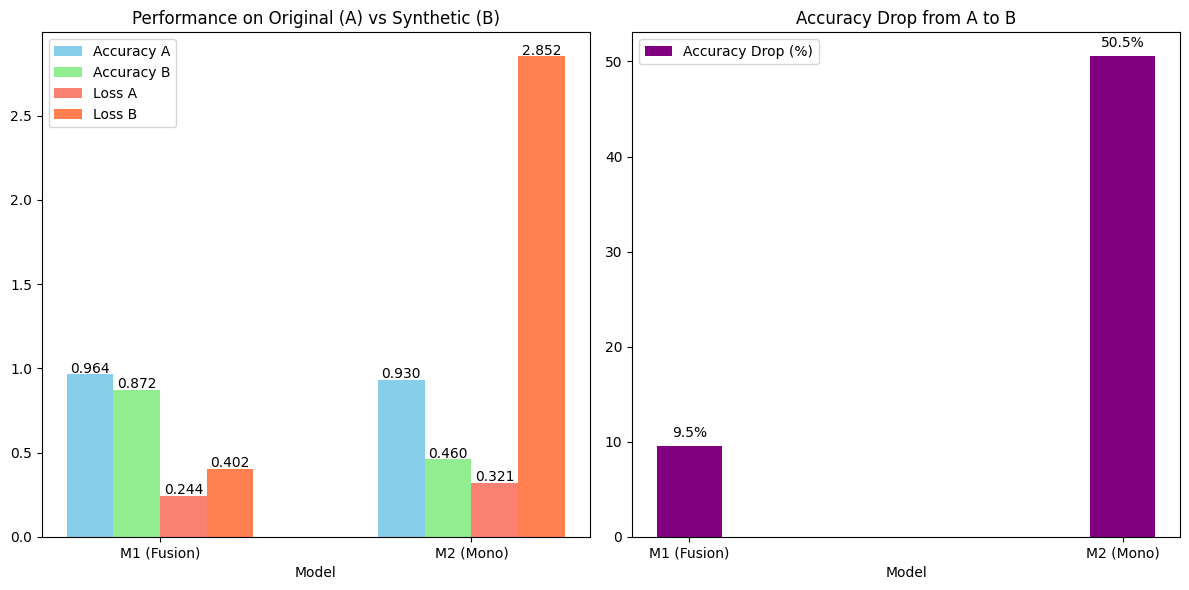

Comparison plot saved as 'model_comparison.png'


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

# Load and preprocess dataset
def load_and_preprocess_data(csv_path, feature_dim=512):
    data = pd.read_csv(csv_path)
    valid_labels = {'Bypass', 'Downloader', 'Injector', 'Payload', 'TaskExecution'}
    original_rows = len(data)
    data = data[data['Label'].isin(valid_labels)]
    removed_rows = original_rows - len(data)
    if removed_rows > 0:
        print(f"{csv_path}: Removed {removed_rows} rows with invalid labels.")
    if data.empty:
        raise ValueError(f"{csv_path}: No rows remain after filtering.")

    features = np.array([np.fromstring(vec, sep=' ') for vec in data['FusionVector']])
    assert features.shape[1] == feature_dim, f"{csv_path}: Expected {feature_dim} features, got {features.shape[1]}"

    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    features = features.reshape(-1, feature_dim, 1)

    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(data['Label'])
    labels = tf.keras.utils.to_categorical(labels, num_classes=5)

    return features, labels, scaler, label_encoder

# M1: Fusion Model (CNN+BiLSTM+Transformer)
def create_fusion_model(input_shape=(512, 1), num_classes=5):
    input_layer = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.005))(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.005))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.005)))(x)
    x = Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.005)))(x)
    transformer = MultiHeadAttention(num_heads=8, key_dim=64)
    x = transformer(x, x)
    x = LayerNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.005))(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# M2: Mono Model (MLP)
def create_mono_model(input_shape=(512, 1), num_classes=5):
    input_layer = Input(shape=input_shape)
    x = Flatten()(input_layer)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate model
def train_and_evaluate(model, features_a, labels_a, features_b, labels_b, model_name, test_size=0.2, epochs=50, batch_size=32):
    # Split Dataset A
    try:
        X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
            features_a, labels_a, test_size=test_size, stratify=labels_a.argmax(axis=1), random_state=42
        )
    except ValueError as e:
        print(f"{model_name} on Dataset A: Error in train_test_split: {e}")
        return None, None, None, None

    # Train on A
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train_a, y_train_a,
        validation_data=(X_test_a, y_test_a),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )

    # Test on A
    loss_a, accuracy_a = model.evaluate(X_test_a, y_test_a, verbose=0)
    print(f"{model_name} on Dataset A: Test Accuracy: {accuracy_a:.4f}, Test Loss: {loss_a:.4f}")

    # Test on B
    loss_b, accuracy_b = model.evaluate(features_b, labels_b, verbose=0)
    print(f"{model_name} on Dataset B: Test Accuracy: {accuracy_b:.4f}, Test Loss: {loss_b:.4f}")

    # Compute percentage drop
    accuracy_drop = (accuracy_a - accuracy_b) / accuracy_a * 100 if accuracy_a > 0 else 0

    return accuracy_a, loss_a, accuracy_b, loss_b, accuracy_drop

# Visualize results
def visualize_comparison(results):
    models = ['M1 (Fusion)', 'M2 (Mono)']
    accuracies_a = [results['M1']['accuracy_a'], results['M2']['accuracy_a']]
    accuracies_b = [results['M1']['accuracy_b'], results['M2']['accuracy_b']]
    losses_a = [results['M1']['loss_a'], results['M2']['loss_a']]
    losses_b = [results['M1']['loss_b'], results['M2']['loss_b']]
    drops = [results['M1']['drop'], results['M2']['drop']]

    x = np.arange(len(models))
    width = 0.15

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot accuracies and losses
    ax1.bar(x - width*1.5, accuracies_a, width, label='Accuracy A', color='skyblue')
    ax1.bar(x - width/2, accuracies_b, width, label='Accuracy B', color='lightgreen')
    ax1.bar(x + width/2, losses_a, width, label='Loss A', color='salmon')
    ax1.bar(x + width*1.5, losses_b, width, label='Loss B', color='coral')

    ax1.set_xlabel('Model')
    ax1.set_title('Performance on Original (A) vs Synthetic (B)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.legend()

    # Add value labels
    for i, v in enumerate(accuracies_a):
        ax1.text(i - width*1.5, v + 0.01, f"{v:.3f}", ha='center')
    for i, v in enumerate(accuracies_b):
        ax1.text(i - width/2, v + 0.01, f"{v:.3f}", ha='center')
    for i, v in enumerate(losses_a):
        ax1.text(i + width/2, v + 0.01, f"{v:.3f}", ha='center')
    for i, v in enumerate(losses_b):
        ax1.text(i + width*1.5, v + 0.01, f"{v:.3f}", ha='center')

    # Plot accuracy drops
    ax2.bar(x, drops, width, label='Accuracy Drop (%)', color='purple')
    ax2.set_xlabel('Model')
    ax2.set_title('Accuracy Drop from A to B')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models)
    ax2.legend()

    for i, v in enumerate(drops):
        ax2.text(i, v + 1, f"{v:.1f}%", ha='center')

    plt.tight_layout()
    plt.savefig("model_comparison.png")
    plt.show()
    print("Comparison plot saved as 'model_comparison.png'")

# Main execution
if __name__ == "__main__":
    # Paths to datasets
    original_csv = "./dataset/fusion_with_vector_extended.csv"
    synthetic_csv = "./GAN/synthetic_powershell_malware.csv"

    # Load datasets
    try:
        features_a, labels_a, scaler_a, encoder_a = load_and_preprocess_data(original_csv)
        print("Loaded original dataset (A)")
    except Exception as e:
        print(f"Error loading original dataset: {e}")
        exit(1)

    try:
        features_b, labels_b, scaler_b, encoder_b = load_and_preprocess_data(synthetic_csv)
        print("Loaded synthetic dataset (B)")
    except Exception as e:
        print(f"Error loading synthetic dataset: {e}")
        exit(1)

    # Evaluate models
    results = {'M1': {}, 'M2': {}}

    # M1: Fusion Model
    m1 = create_fusion_model()
    result_m1 = train_and_evaluate(m1, features_a, labels_a, features_b, labels_b, "M1 (Fusion Model)")
    if result_m1[0] is not None:
        results['M1']['accuracy_a'], results['M1']['loss_a'], results['M1']['accuracy_b'], results['M1']['loss_b'], results['M1']['drop'] = result_m1
    else:
        print("Failed to evaluate M1. Check dataset size or labels.")
        exit(1)

    # M2: Mono Model
    m2 = create_mono_model()
    result_m2 = train_and_evaluate(m2, features_a, labels_a, features_b, labels_b, "M2 (Mono Model)")
    if result_m2[0] is not None:
        results['M2']['accuracy_a'], results['M2']['loss_a'], results['M2']['accuracy_b'], results['M2']['loss_b'], results['M2']['drop'] = result_m2
    else:
        print("Failed to evaluate M2. Check dataset size or labels.")
        exit(1)

    # Visualize results
    visualize_comparison(results)